Copyright 2018 Google LLC
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [0]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn
import json

from IPython.display import set_matplotlib_formats

seaborn.set_style("whitegrid")
set_matplotlib_formats('png')

In [0]:
def ScaleTime(num, unit):
  '''Scales time to nanos.'''
  if (unit == 'ns'):
    return num
  raise Exception('Unknown time unit: ' + unit)

def ParseJsonBenchmark(benchmarks):
  '''Parses json benchmark data into a list of dictionaries.
  
    "benchmarks": [
      {
        "name": "BM<FindHit_Hot, __gnu_cxx::hash_set, 4, Density::kMin>/16/iterations:20000000",
        "iterations": 33572864,
        "real_time": 1.2866112288867752e+01,
        "cpu_time": 1.2866659097061246e+01,
        "time_unit": "ns",
        "label": "lf=0.50 cmp=1.248 size=194 num_sets=338"
      },
      ...
    ]
  '''
  
  # we drop the /16/iterations:200000 portion because the size is more accurately kept in the label under 'size'
  name_rx = re.compile(r'BM<(?P<benchmark>[^_]+)_+(?P<cache>Hot|Cold), (?P<table>[^,]+), +(?P<entry_size>\d+), Density::k(?P<density>Min|Max)>')  
  rows_to_parse = ['cmp', 'size', 'lf', 'num_sets']
 
  res = []   
  for b in benchmarks:
    try:
      # Detect tests that we just skipped
      if b['iterations'] == 0: continue
        
      m = name_rx.search(b['name'])
      row = m.groupdict()
      row['time_ns'] = ScaleTime(b['real_time'], b['time_unit'])
      row['cpu_ns'] = ScaleTime(b['cpu_time'], b['time_unit'])     
      for l in b['label'].split():
        k, v = l.split('=')
        row[k] = float(v)
      res.append(row)
    except:
      print(b)
      raise
  return res

def FrameParsedBenchmark(data):
  '''Returns a pivot table of the benchmark data from a list of dictionaries.'''
  framed = pd.DataFrame(data)
  desired_values = ['time_ns', 'lf', 'cpu_ns', 'cmp', 'allocs']
  pivot_args = {
    'columns': ['benchmark', 'table', 'entry_size', 'cache', 'density'],
    'index' : ['size'],
  }
  
  results = {}
  for v in desired_values:
    if v in framed:
      results[v] = pd.pivot_table(framed, values=v, **pivot_args)

  return pd.concat(results)

In [3]:
# TODO: figure out if this works in Jupyter
from google.colab import files
uploaded = files.upload()

Saving benchmark-results.json to benchmark-results.json


In [66]:
benchmarks_json = json.loads(uploaded['benchmark-results.json'])
data = FrameParsedBenchmark(ParseJsonBenchmark(benchmarks_json['benchmarks']))
for l in data.axes[1].levels:
  print("%10s: %s" % (l.name, " ".join(l)))

 benchmark: EraseInsert FindHit FindMiss InsertHit InsertManyOrdered InsertManyUnordered Iterate
     table: __gnu_cxx::hash_set folly::F14ValueSet google::dense_hash_set std::unordered_set
entry_size: 4 64
     cache: Cold Hot
   density: Max Min


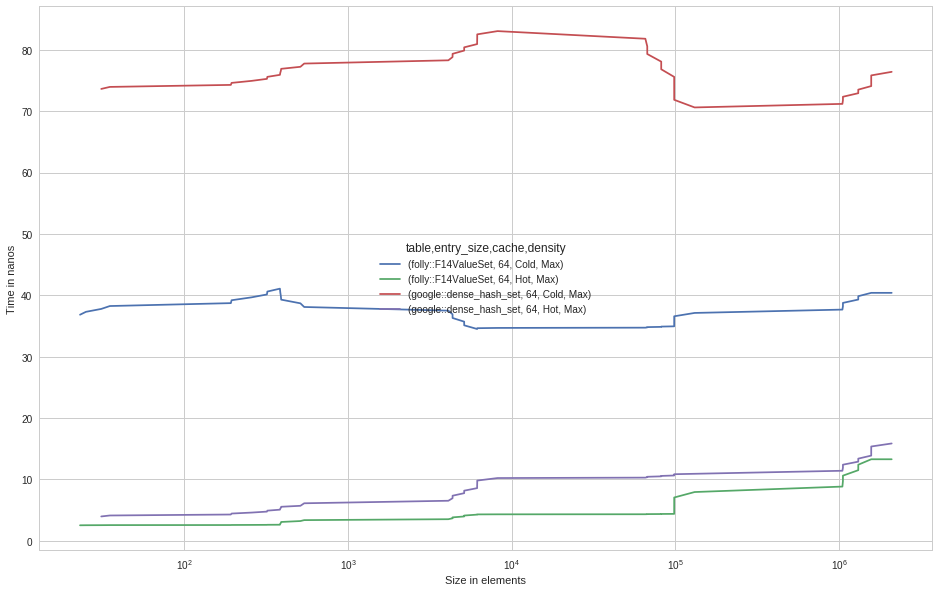

In [71]:
t = ['google::dense_hash_set', 'folly::F14ValueSet']
b = 'Iterate'
s = '64'
w = ['Cold', 'Hot']
o = 'Max'

p = data[b].loc['time_ns'].loc(axis='columns')[t, s, w, o].interpolate().plot(logx=True, legend=True, figsize=(16,10))
p.set_xlabel("Size in elements")
p.set_ylabel("Time in nanos")
pass